In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
import math
import plotly_express as px
from datetime import datetime, timedelta

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from functions import grangerTests, plot_seasonal_decompose, daySignal, addDateParts

In [19]:
#define the ticker symbol
tickerSymbol = 'ETH-USD' #'MSFT'

# Date period
start = dt.datetime(2010,1,1)
end = dt.datetime.now()

#get data on this ticker
tickerData = yf.Ticker(tickerSymbol)
#get the historical prices for this ticker
df = tickerData.history(period='1D', start=start, end=end)

# Removing features with constant values
df = df.loc[:,df.apply(pd.Series.nunique) != 1]

# Some calculated variables
df['day_change'] = df['Close'] - df['Open']
df['day_change_pct'] = (df['day_change'] / df['Open']) * 100
df['day_change_signal'] = df['day_change'].apply(daySignal)

# Lagging close, high and low by one day
for feature in ['Close', 'High', 'Low', 'Volume']:
    df[f"{feature}_lag1"] = df[feature].shift(1).bfill() 

# Adding date features
df = addDateParts(df)

# Exit datetime index
df = df.reset_index()

# View dataframe
df

c:\Users\steph\OneDrive\Documents\GitHub\stock-price-prediction\functions.py:83: FutureWarning:

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)



,Date,Open,High,Low,Close,Volume,day_change,day_change_pct,day_change_signal,Close_lag1,High_lag1,Low_lag1,Volume_lag1,day_of_year,day_of_week,week,month
0,2017-11-09 00:00:00+00:00,308.644989,329.451996,307.056000,320.884003,893249984,12.239014,3.965402,1,320.884003,329.451996,307.056000,8.932500e+08,9,3,45,11
1,2017-11-10 00:00:00+00:00,320.670990,324.717987,294.541992,299.252991,885985984,-21.417999,-6.679120,-1,320.884003,329.451996,307.056000,8.932500e+08,10,4,45,11
2,2017-11-11 00:00:00+00:00,298.585999,319.453003,298.191986,314.681000,842300992,16.095001,5.390407,1,299.252991,324.717987,294.541992,8.859860e+08,11,5,45,11
3,2017-11-12 00:00:00+00:00,314.690002,319.153015,298.513000,307.907990,1613479936,-6.782013,-2.155141,-1,314.681000,319.453003,298.191986,8.423010e+08,12,6,45,11
4,2017-11-13 00:00:00+00:00,307.024994,328.415009,307.024994,316.716003,1041889984,9.691010,3.156424,1,307.907990,319.153015,298.513000,1.613480e+09,13,0,46,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1903,2023-01-25 00:00:00+00:00,1556.807495,1632.241699,1530.797852,1611.711060,10598973448,54.903564,3.526677,1,1556.604248,1639.723877,1551.389771,8.180275e+09,25,2,4,1
1904,2023-01-26 00:00:00+00:00,1611.080933,1626.198242,1586.598145,1603.105957,8395315241,-7.974976,-0.495008,-1,1611.711060,1632.241699,1530.797852,1.059897e+10,26,3,4,1
1905,2023-01-27 00:00:00+00:00,1603.080078,1617.000854,1565.244995,1598.156494,8124465373,-4.923584,-0.307133,-1,1603.105957,1626.198242,1586.598145,8.395315e+09,27,4,4,1
1906,2023-01-28 00:00:00+00:00,1598.125366,1604.704102,1565.390137,1572.435059,5803653357,-25.690308,-1.607528,-1,1598.156494,1617.000854,1565.244995,8.124465e+09,28,5,4,1


## Target variable

In [20]:
feat_ex = 'Close'
px.line(df, x='Date', y=[feat_ex])

## Pre-processing

In [21]:
# Last year as testing period
split = '2023-01-01' 
# Drop columns not available at open
drop_cols = ['Date', 'High', 'Low', 'Volume', 'day_change','day_change_pct', 'day_change_signal']
# Split on date
train = df[df['Date'] <= split].drop(columns=drop_cols)
test = df[df['Date'] > split].drop(columns=drop_cols)
# Features and target
X_train = train.drop(columns=feat_ex)
X_test = test.drop(columns=feat_ex)
y_train = train[feat_ex]
y_test = test[feat_ex]
# Scale features
scaler = MinMaxScaler(feature_range=(0,1))
X_train_scaled = scaler.fit_transform(X_train)#.reshape(-1,1))
X_test_scaled = scaler.transform(X_test)
# Target as np array
y_train, y_test = np.array(y_train), np.array(y_test)
# Reshape for LSTM
X_train_lstm = np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_lstm = np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

In [22]:
print(f"The shape of the training data is {X_train_lstm.shape} features and {y_train.shape} target")
print("------------------------------")
print(f"The shape of the testing data is {X_test_lstm.shape} features and {y_test.shape} target")

The shape of the training data is (1880, 9, 1) features and (1880,) target
------------------------------
The shape of the testing data is (28, 9, 1) features and (28,) target


In [23]:
# Last year as testing period
split = '2023-01-01' 
# Drop columns not available at open
drop_cols = ['Date', 'High', 'Low', 'Volume', 'day_change','day_change_pct', 'day_change_signal']
# Split index
split_idx = df[df['Date']==split].index[0]
# Walk forward predictions
test_idx = df.index[df.index > split_idx]
predictions = list()
for i in test_idx:
    # Split on date
    train = df[df.index <= split_idx].drop(columns=drop_cols)
    test = df[df.index == i].drop(columns=drop_cols)
    # Features and target
    X_train = train.drop(columns=feat_ex)
    X_test = test.drop(columns=feat_ex)
    y_train = train[feat_ex]
    y_test = test[feat_ex]
    # Scale features
    scaler = MinMaxScaler(feature_range=(0,1))
    X_train_scaled = scaler.fit_transform(X_train)#.reshape(-1,1))
    X_test_scaled = scaler.transform(X_test)
    # Target as np array
    y_train, y_test = np.array(y_train), np.array(y_test)
    # Reshape for LSTM
    X_train_lstm = np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
    X_test_lstm = np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1], 1))
    # Iterate split index
    split_idx += 1
    # Create model
    model = keras.Sequential()
    model.add(layers.LSTM(100, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)))
    model.add(layers.LSTM(100, return_sequences=False))
    model.add(layers.Dense(25))
    model.add(layers.Dense(1))
    # Compile & fit model
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train_lstm, y_train, batch_size= 1, epochs=10)
    # Predict next point
    y_pred = model.predict(X_test_lstm)
    predictions.append(y_pred)
    

Epoch 1/10
1880/1880 [==============================] - 14s 6ms/step - loss: 1026795.9375
Epoch 2/10
1880/1880 [==============================] - 9s 5ms/step - loss: 64210.1445
Epoch 3/10
1880/1880 [==============================] - 9s 5ms/step - loss: 33818.3711
Epoch 4/10
1880/1880 [==============================] - 10s 5ms/step - loss: 21258.5371
Epoch 5/10
1880/1880 [==============================] - 10s 5ms/step - loss: 17430.5293
Epoch 6/10
1880/1880 [==============================] - 10s 5ms/step - loss: 17256.8262
Epoch 7/10
1880/1880 [==============================] - 10s 5ms/step - loss: 17226.3301
Epoch 8/10
1880/1880 [==============================] - 10s 5ms/step - loss: 14093.4932
Epoch 9/10
1880/1880 [==============================] - 10s 5ms/step - loss: 14050.9570
Epoch 10/10
1/1 [==============================] - 1s 909ms/step
Epoch 1/10
1881/1881 [==============================] - 13s 5ms/step - loss: 998549.2500
Epoch 2/10
1881/1881 [==============================] 

In [30]:
predictions

[array([[1069.0474]], dtype=float32),
 array([[1242.6897]], dtype=float32),
 array([[1179.1804]], dtype=float32),
 array([[1283.9316]], dtype=float32),
 array([[1208.2827]], dtype=float32),
 array([[1348.91]], dtype=float32),
 array([[1262.8687]], dtype=float32),
 array([[1292.5211]], dtype=float32),
 array([[1215.9457]], dtype=float32),
 array([[1550.2097]], dtype=float32),
 array([[1385.3853]], dtype=float32),
 array([[1597.3618]], dtype=float32),
 array([[1275.458]], dtype=float32),
 array([[1595.0322]], dtype=float32),
 array([[1591.4379]], dtype=float32),
 array([[1608.3464]], dtype=float32),
 array([[1646.3478]], dtype=float32),
 array([[1484.5178]], dtype=float32),
 array([[1491.2251]], dtype=float32),
 array([[1657.7659]], dtype=float32),
 array([[1625.5958]], dtype=float32),
 array([[1683.4955]], dtype=float32),
 array([[1577.9543]], dtype=float32),
 array([[1588.9092]], dtype=float32),
 array([[1591.565]], dtype=float32),
 array([[1552.0397]], dtype=float32),
 array([[1694.29

In [35]:
pred2 = []
for i in predictions:
    pred2.append(i[0][0])

<AxesSubplot: >

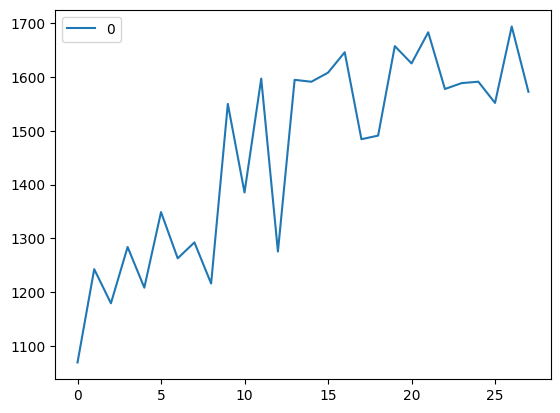

In [38]:
pd.DataFrame(pred2).plot()

In [41]:
pd.DataFrame(y_test)

,0
0,1609.816162


In [ ]:
results_df = df[['Date']]
results_df = results_df[results_df.index > split]
predictions = model.predict(X_test_lstm)
results_df['predictions'] = predictions
results_df = results_df.set_index('Date').join(df[['Date', feat_ex]].set_index('Date'), how='outer')
# Plot results
px.line(results_df, x=results_df.index, y=[feat_ex, 'predictions'])

## LSTM - walk forward

In [6]:
def createLSTM(X_train):
    model = keras.Sequential()
    model.add(layers.LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(layers.LSTM(100, return_sequences=False))
    model.add(layers.Dense(25))
    model.add(layers.Dense(1))
    #model.summary()
    return model

## LSTM

In [91]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 9, 100)            40800     
                                                                 
 lstm_19 (LSTM)              (None, 100)               80400     
                                                                 
 dense_18 (Dense)            (None, 25)                2525      
                                                                 
 dense_19 (Dense)            (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [92]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train_lstm, y_train, batch_size= 1, epochs=30)

Epoch 1/30
1545/1545 [==============================] - 9s 4ms/step - loss: 1334700.6250
Epoch 2/30
1545/1545 [==============================] - 8s 5ms/step - loss: 160273.6875
Epoch 3/30
1545/1545 [==============================] - 8s 5ms/step - loss: 41091.3281
Epoch 4/30
1545/1545 [==============================] - 8s 5ms/step - loss: 22666.7891
Epoch 5/30
1545/1545 [==============================] - 8s 5ms/step - loss: 19921.1660
Epoch 6/30
1545/1545 [==============================] - 8s 5ms/step - loss: 19165.2910
Epoch 7/30
1545/1545 [==============================] - 9s 6ms/step - loss: 14992.4229
Epoch 8/30
1545/1545 [==============================] - 8s 5ms/step - loss: 13887.8496
Epoch 9/30
1545/1545 [==============================] - 8s 5ms/step - loss: 15999.6289
Epoch 10/30
1545/1545 [==============================] - 8s 5ms/step - loss: 12712.1816
Epoch 11/30
1545/1545 [==============================] - 8s 5ms/step - loss: 12887.1680
Epoch 12/30
1545/1545 [===============

In [93]:
hist_df = pd.DataFrame(history.history)
px.line(hist_df, y=['loss'])

In [94]:
results_df = df[['Date']]
results_df = results_df[results_df['Date'] > split]
predictions = model.predict(X_test_lstm)
results_df['predictions'] = predictions
results_df = results_df.set_index('Date').join(df[['Date', feat_ex]].set_index('Date'), how='outer')
results_df

12/12 [==============================] - 1s 7ms/step


,predictions,Close
Date,,
2017-11-09 00:00:00+00:00,NaN,320.884003
2017-11-10 00:00:00+00:00,NaN,299.252991
2017-11-11 00:00:00+00:00,NaN,314.681000
2017-11-12 00:00:00+00:00,NaN,307.907990
2017-11-13 00:00:00+00:00,NaN,316.716003
...,...,...
2023-01-25 00:00:00+00:00,1593.281128,1611.711060
2023-01-26 00:00:00+00:00,1651.330322,1603.105957
2023-01-27 00:00:00+00:00,1642.680420,1598.156494


In [95]:
px.line(results_df, x=results_df.index, y=[feat_ex, 'predictions'])

In [96]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

perf_dict = dict()
model_name = 'lstm'
perf_dict[model_name] = {
    'r2': r2_score(y_test, predictions),
    'mae': mean_absolute_error(y_test, predictions),
    'mape': mean_absolute_percentage_error(y_test, predictions)*100,
    'rmse': mean_squared_error(y_test, predictions, squared=False),
}

pd.DataFrame(perf_dict).T

,mae,mape,r2,rmse
lstm,69.24333,3.787606,0.980619,97.913734


## Cross validation

In [97]:
drop_cols = ['Date', 'High', 'Low', 'Volume', 'day_change','day_change_pct', 'day_change_signal']
# Drop columns not available at open
X = df.drop(columns=drop_cols)
# Drop target
X = X.drop(columns=feat_ex)
# Create target
y = df[feat_ex]

In [98]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(max_train_size=None, n_splits=5)
split = 1
pred_dict = dict()
for train_index, test_index in tscv.split(X):
    print(f"split: {split}")
    print("TRAIN:", train_index.max(), "TEST:", test_index.max()) 
    #print("TRAIN:", train_index, "TEST:", test_index) 
    X_train, X_test = X[:train_index.max()], X[train_index.max():test_index.max()]
    y_train, y_test = y[:train_index.max()], y[train_index.max():test_index.max()]
    print(f"Training {X_train.shape} features and {y_train.shape} target")
    print("---------------")
    print(f"Testing {X_test.shape} features and {y_test.shape} target")
    # Scale features
    scaler = MinMaxScaler(feature_range=(0,1))
    X_train_scaled = scaler.fit_transform(X_train)#.reshape(-1,1))
    X_test_scaled = scaler.transform(X_test)
    # Target as np array
    y_train, y_test = np.array(y_train), np.array(y_test)
    # Reshape for LSTM
    X_train_lstm = np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
    X_test_lstm = np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1], 1))
    # Define model
    model = keras.Sequential()
    model.add(layers.LSTM(100, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)))
    model.add(layers.LSTM(100, return_sequences=False))
    model.add(layers.Dense(25))
    model.add(layers.Dense(1))
    # Compile and fit
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train_lstm, y_train, batch_size= 1, epochs=30)
    # Predict test set
    predictions = model.predict(X_test_lstm)
    #pred_dict[f"split: {split}"] = predictions
    perf_dict[f"split: {split}"] = {
        'r2': r2_score(y_test, predictions),
        'mae': mean_absolute_error(y_test, predictions),
        'mape': mean_absolute_percentage_error(y_test, predictions)*100,
        'rmse': mean_squared_error(y_test, predictions, squared=False),
    }
    # Iterate split
    split += 1

split: 1
TRAIN: 317 TEST: 635
Training (317, 9) features and (317,) target
---------------
Testing (318, 9) features and (318,) target
Epoch 1/30
317/317 [==============================] - 5s 5ms/step - loss: 228921.8438
Epoch 2/30
317/317 [==============================] - 2s 6ms/step - loss: 69001.8594
Epoch 3/30
317/317 [==============================] - 2s 6ms/step - loss: 62607.6641
Epoch 4/30
317/317 [==============================] - 2s 6ms/step - loss: 24734.6738
Epoch 5/30
317/317 [==============================] - 2s 6ms/step - loss: 10781.6934
Epoch 6/30
317/317 [==============================] - 2s 6ms/step - loss: 6843.5293
Epoch 7/30
317/317 [==============================] - 2s 6ms/step - loss: 5990.7725
Epoch 8/30
317/317 [==============================] - 2s 6ms/step - loss: 3870.3711
Epoch 9/30
317/317 [==============================] - 2s 6ms/step - loss: 3556.2954
Epoch 10/30
317/317 [==============================] - 2s 6ms/step - loss: 3535.2173
Epoch 11/30
317/31

In [101]:
pd.DataFrame(perf_dict).T.sort_values(by='rmse')

,r2,mae,mape,rmse
split: 2,0.803235,13.725543,7.995576,16.078393
split: 1,0.258963,41.663847,31.227426,50.849238
split: 5,0.984885,58.036998,3.528295,79.640428
lstm,0.980619,69.243330,3.787606,97.913734
split: 3,0.724314,194.612701,11.501801,376.405679
split: 4,-0.846521,822.937895,22.911566,1025.279430
